In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data

subroutine.py

In [2]:
import csv
def return_HM_npy(csvfile_path):
    H=[]
    M=[]
    with open(csvfile_path, 'r') as f:
        reader=csv.reader(f)
        header=next(reader) #skip header
        for row in reader:
            H.append(float(row[0]))
            M.append(float(row[1]))
    return np.array(H), np.array(M)

def accept_middle(H, M, noise_std=0.1, f=None):
    noise=abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else: return False

def generate_data(noise_std=0.1, datasize=10000, Hrange=[0.0, 6.0], Mrange=[0.0, 2.0], f=None):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1])
        M=np.random.uniform(Mrange[0], Mrange[1])
        if accept_middle(H, M, noise_std, f) and len(Hp)<datasize:
            Hp.append([H])
            Mp.append([M])
            Fp.append([0])
        elif len(Hn)<datasize:
            Hn.append([H])
            Mn.append([M])
            Fn.append([1])
        if len(Hp)>=datasize and len(Hn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(H, M, Positive_HM, Negative_HM, f):
    plt.xlabel('H')
    plt.ylabel('M')
    plt.plot(Negative_HM[0], Negative_HM[1], 'y.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'b.', label='positive')
    hs=np.linspace(np.min(H), np.max(H), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(H, M, 'ro', label='data')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

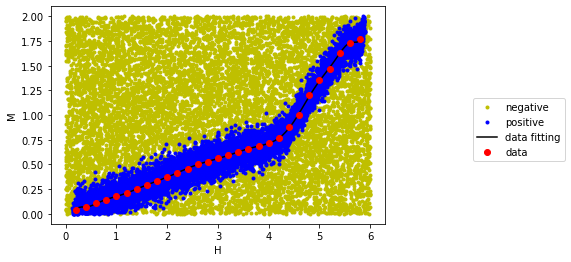

In [3]:
H,M=return_HM_npy('MHfile.csv')
f=np.poly1d(np.polyfit(H,M,deg=15))
Positive_HM, Negative_HM = generate_data(datasize=10000, f=f)
plot_all(H, M, Positive_HM, Negative_HM, f)

## Reformat training data
Make training data by class called 'Dataset'.

In [4]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, pi, eta=None):
    ''' returning Pi'''
    F=pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        self.lamb=nn.Linear(1, 1, bias=False)
        self.m2=nn.Linear(1, 1, bias=False)
        self.alpha=nn.Linear(1, 1, bias=False)
        self.beta=nn.Linear(1, 1, bias=False)
        
        #fixed parameters
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
        
    def show_lamb(self):
        return self.lamb(self.one)
    def show_m2(self):
        return self.m2(self.one)
    def show_alpha(self):
        return self.alpha(self.one)
    def show_beta(self):
        return self.beta(self.one)
    
    def penalty(self, coef_list=None):
        penalty=0
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layer))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        pH=self.Hs[0](self.one)
        for i in range(1, self.N_layer):
            H = self.Hs[i]
            if H==self.Hs[9]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = penalty + c_reg2*(1/self.eta_fin - H(self.one))**2
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
    
    def forward(self, H=None, M=None):
        #initial layer
        D=torch.sqrt(torch.abs(1+4*self.m2(self.one)/(self.Hs[0](self.one)**2)))
        phi=self.alpha(self.one)*H + self.beta(self.one)*M
        pi=(d/2)*(D-1)*self.alpha(self.one)*H + (d/2)*(-D-1)*self.beta(self.one)*M
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2(self.one), 
                              lamb=self.lamb(self.one), del_eta=self.del_eta)
        ff=f(phi, pi, eta=eta(self.N_layer, self.eta_ini, self.eta_fin, self.N_layer))
        final = t(ff, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, pi=None, answer=None, reg_coef_list=None):
        model_output=self.forward(H=phi, M=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w=np.random.normal(2, 1)
        Model.Hs[i].weight.data.fill_(w)
    m2=np.random.normal(2, 1)
    lamb=np.random.normal(1, 1)
    alpha=np.random.uniform(-0.5, 0.5)
    beta=np.random.uniform(-0.5, 0.5)
    Model.m2.weight.data.fill_(m2)
    Model.lamb.weight.data.fill_(lamb)
    Model.alpha.weight.data.fill_(alpha)
    Model.beta.weight.data.fill_(beta)    

In [10]:
d=4
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
c_reg1=0.003
c_reg2=0.0001

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = torch.optim.Adam(Test.parameters())
Test.train()
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(c_reg1*eta(i, eta_ini, eta_fin, N_layer)**4)
    
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]
print("H: ", np.array(a))
print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))

H:  [ 2.781563    2.0304234   1.9638635   0.2738948   1.4966018  -0.09723514
  1.9718783   1.5011768   4.140897    3.5539558 ]
m2: 0.41542527079582214, lambda: -0.2258039116859436, alpha: 0.0035087913274765015, beta: 0.324777215719223


# 3. Train NN

In [11]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('M', fontsize=12)
    al.set_ylabel('H', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

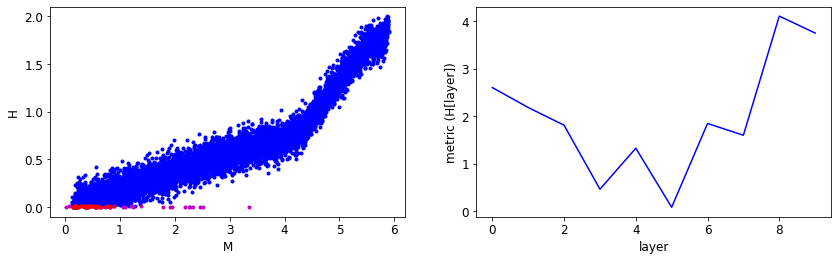

training epoch: 0,   loss: 0.2647647559642792
m2: 0.4728225767612457, lambda: -0.3028036653995514, alpha: -0.07009871304035187, beta: 0.34501975774765015
[2.60379648 2.18404508 1.81085873 0.46321133 1.3262527  0.08288954
 1.84673691 1.60054493 4.10894203 3.75269222]


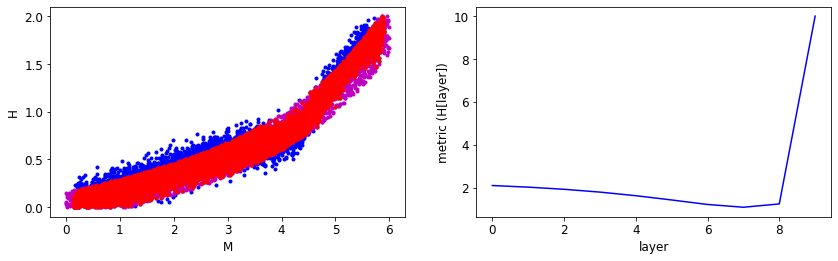

training epoch: 100,   loss: 0.010645674541592598
m2: 0.36529988050460815, lambda: -0.7019095420837402, alpha: 0.12799617648124695, beta: 0.035543058067560196
[2.09250832 2.01671147 1.91728008 1.78540921 1.61790419 1.41803133
 1.20856023 1.07888448 1.23329246 9.99999905]


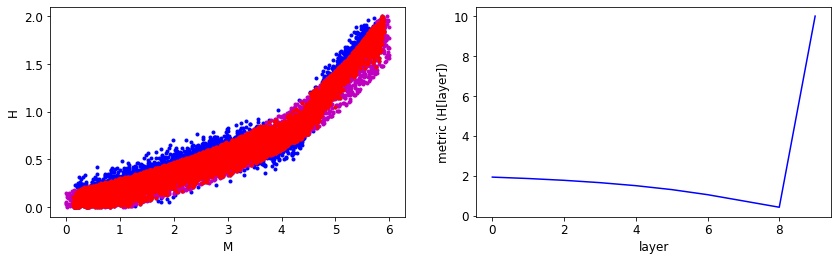

training epoch: 200,   loss: 0.010469273664057255
m2: 0.34383004903793335, lambda: -0.6707972884178162, alpha: 0.1300867646932602, beta: 0.041758887469768524
[ 1.92544186  1.85488605  1.76474535  1.64769125  1.49643576  1.29961121
  1.04473567  0.73034698  0.41412356 10.        ]


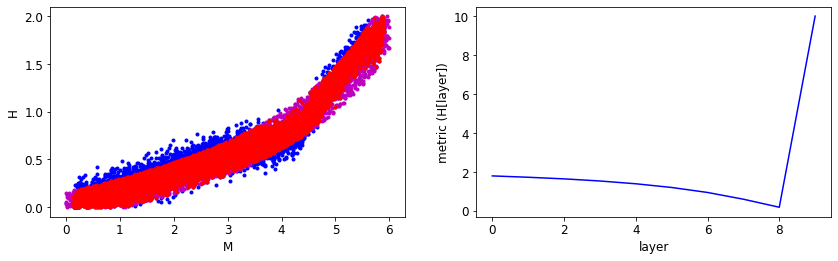

training epoch: 300,   loss: 0.010406495071947575
m2: 0.30817776918411255, lambda: -0.6292503476142883, alpha: 0.13709618151187897, beta: 0.04772011190652847
[ 1.79375112  1.72430885  1.64216506  1.5329814   1.38967037  1.19986653
  0.94339591  0.59689754  0.184613   10.        ]


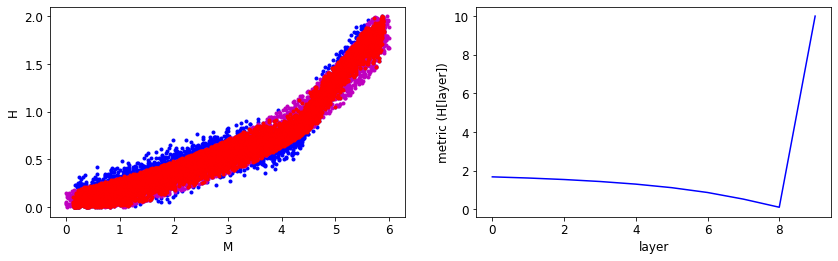

training epoch: 400,   loss: 0.010407742112874985
m2: 0.276391863822937, lambda: -0.576103687286377, alpha: 0.13948382437229156, beta: 0.05005369335412979
[ 1.68091071  1.62084234  1.54295611  1.44062293  1.304546    1.12155533
  0.8714819   0.5284425   0.10807224 10.        ]


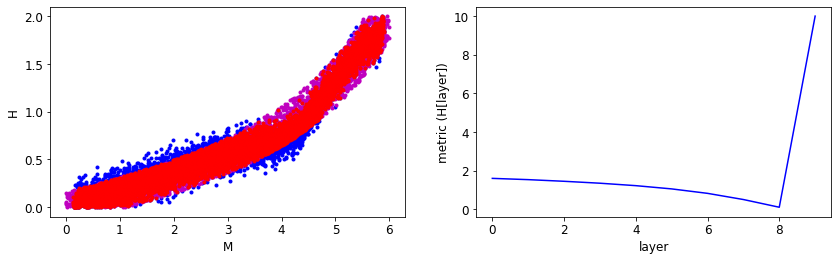

training epoch: 500,   loss: 0.010945875197649002
m2: 0.23390257358551025, lambda: -0.5243331789970398, alpha: 0.1464826613664627, beta: 0.05163121968507767
[ 1.59336936  1.52782893  1.44241083  1.34257042  1.21601379  1.04778504
  0.8172428   0.49723145  0.09756047 10.        ]


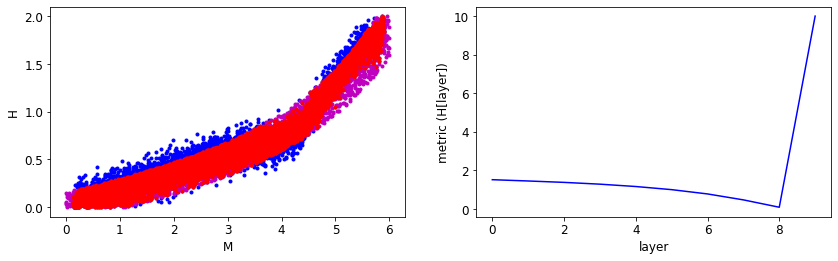

training epoch: 600,   loss: 0.01024351641535759
m2: 0.2073034644126892, lambda: -0.4676734507083893, alpha: 0.1492595374584198, beta: 0.05683431401848793
[ 1.5129993   1.44639885  1.37408447  1.28099597  1.15929925  0.9969219
  0.77433127  0.46611208  0.08410807 10.        ]


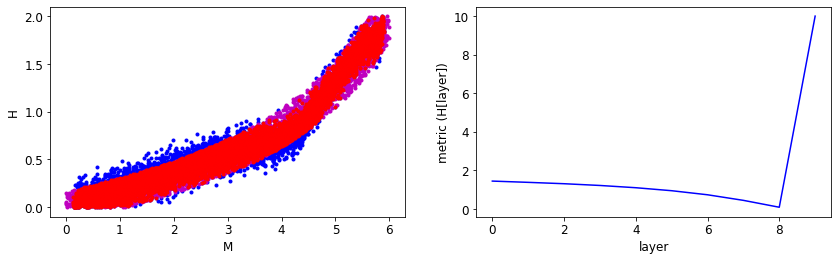

training epoch: 700,   loss: 0.010417792946100235
m2: 0.18498192727565765, lambda: -0.4265013039112091, alpha: 0.15783876180648804, beta: 0.05870504304766655
[ 1.44219387  1.37669003  1.30572844  1.21502757  1.0980202   0.94301713
  0.73212224  0.44260731  0.08536878 10.        ]


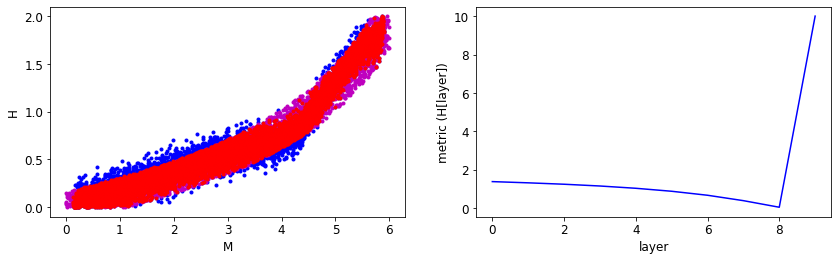

training epoch: 800,   loss: 0.01040806993842125
m2: 0.1685277819633484, lambda: -0.38346436619758606, alpha: 0.16073741018772125, beta: 0.06099936366081238
[ 1.37801862  1.31457198  1.24134874  1.14926374  1.03073835  0.87524396
  0.66711497  0.38584438  0.04265271 10.        ]


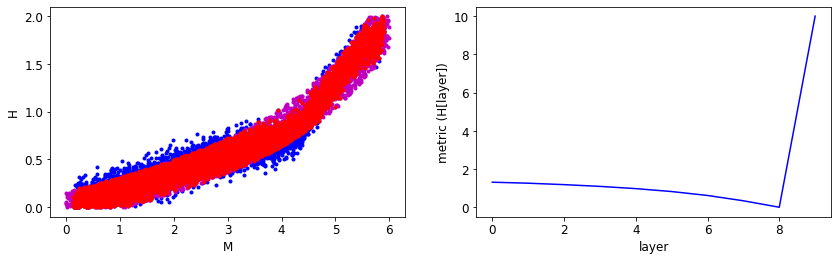

training epoch: 900,   loss: 0.010461063124239445
m2: 0.15308642387390137, lambda: -0.3487800359725952, alpha: 0.16635937988758087, beta: 0.062361471354961395
[ 1.32094014  1.26851451  1.19390738  1.10207176  0.98552054  0.83275098
  0.62744141  0.34959474  0.01227574 10.        ]


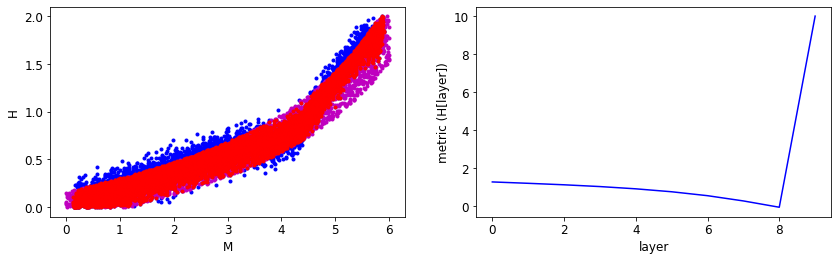

training epoch: 1000,   loss: 0.010849125683307648
m2: 0.1388639658689499, lambda: -0.3210500180721283, alpha: 0.16807912290096283, beta: 0.06727546453475952
[ 1.27537906  1.20313501  1.12509191  1.0317359   0.91312903  0.75818712
  0.55179328  0.27570051 -0.05621014 10.        ]


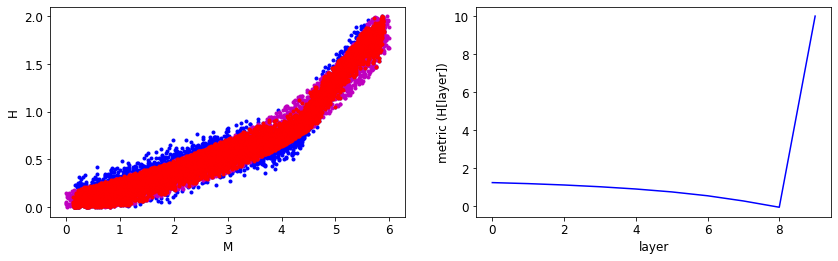

training epoch: 1100,   loss: 0.010216735303401947
m2: 0.13528473675251007, lambda: -0.2957790493965149, alpha: 0.17587999999523163, beta: 0.0691552683711052
[ 1.22868085  1.17519379  1.10323811  1.01040018  0.89199197  0.73888326
  0.53530085  0.26159087 -0.06930438 10.        ]


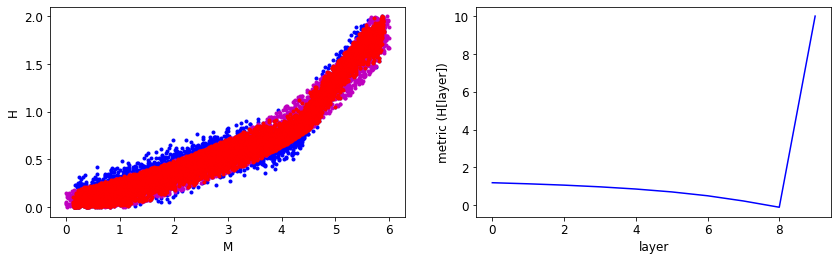

training epoch: 1200,   loss: 0.01039055734872818
m2: 0.12280235439538956, lambda: -0.27861645817756653, alpha: 0.18093787133693695, beta: 0.07057353109121323
[ 1.19551969  1.13806796  1.06804252  0.97823852  0.86225671  0.71008199
  0.5060153   0.23097309 -0.10043256 10.        ]


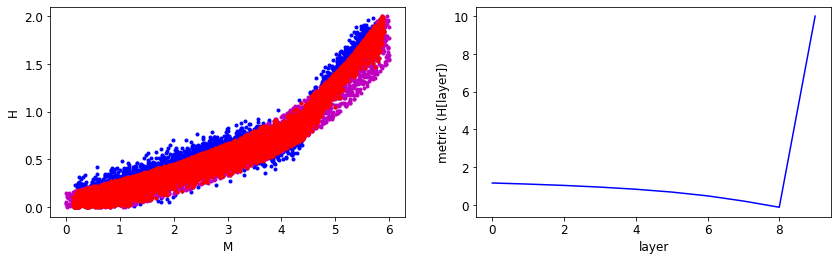

training epoch: 1300,   loss: 0.01033985149115324
m2: 0.1120050847530365, lambda: -0.26017290353775024, alpha: 0.18339765071868896, beta: 0.0745767205953598
[ 1.16908753  1.11063349  1.04015291  0.95171022  0.83847588  0.68910789
  0.48736665  0.21454342 -0.11448029 10.        ]


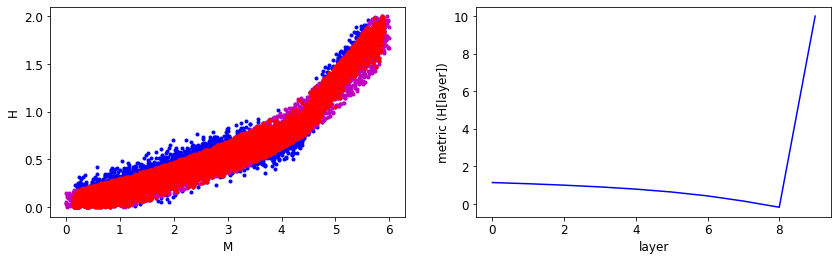

training epoch: 1400,   loss: 0.01058344729244709
m2: 0.10968274623155594, lambda: -0.2524120807647705, alpha: 0.18794932961463928, beta: 0.0757620632648468
[ 1.14037979  1.07745039  1.0013361   0.90864146  0.79092604  0.63655412
  0.43027717  0.15490304 -0.17411679 10.        ]


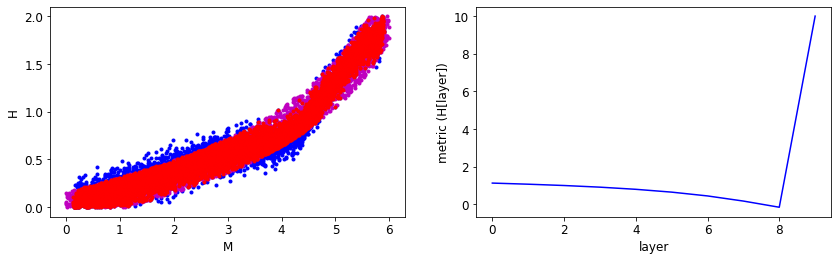

training epoch: 1500,   loss: 0.01030737441033125
m2: 0.1042872816324234, lambda: -0.24268609285354614, alpha: 0.19247478246688843, beta: 0.07468724250793457
[ 1.11849427  1.05898929  0.98953378  0.90161473  0.78748119  0.63722718
  0.43493959  0.16205473 -0.16652933 10.        ]


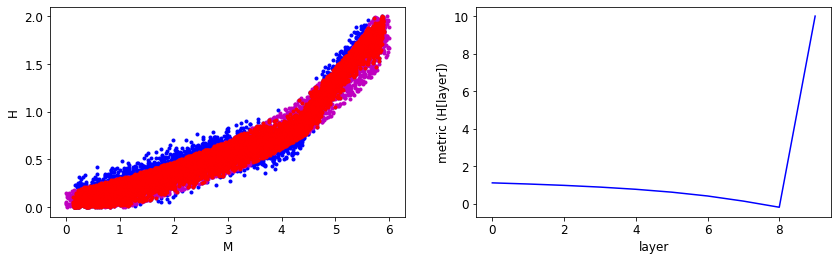

training epoch: 1600,   loss: 0.010465282015502453
m2: 0.10176530480384827, lambda: -0.23274029791355133, alpha: 0.19174306094646454, beta: 0.07726234197616577
[ 1.10169244  1.04098594  0.96805751  0.87651092  0.75906706  0.60583419
  0.40154782  0.12820289 -0.19918446 10.        ]


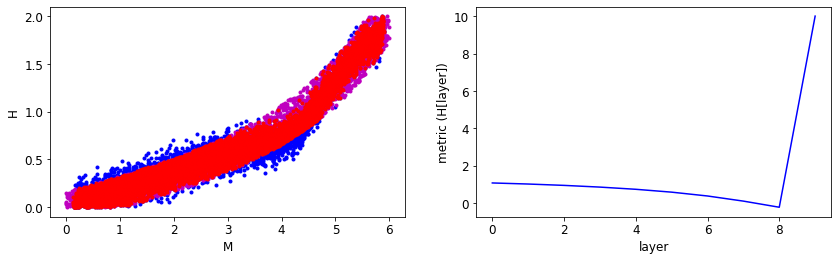

training epoch: 1700,   loss: 0.010251536034047604
m2: 0.10168971866369247, lambda: -0.22839833796024323, alpha: 0.19396868348121643, beta: 0.07514160126447678
[ 1.0814991   1.02419424  0.951774    0.86008245  0.74297774  0.58970189
  0.38481519  0.11083486 -0.21675108 10.        ]


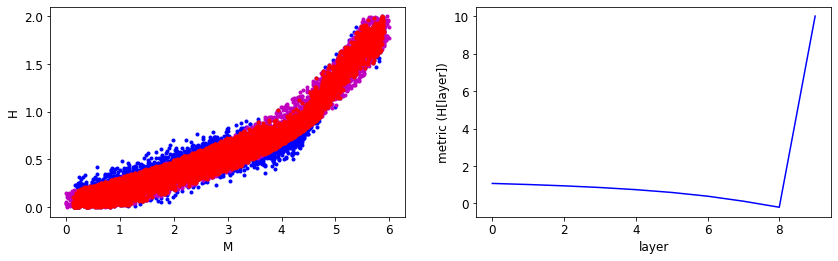

training epoch: 1800,   loss: 0.010344252921640873
m2: 0.09681542962789536, lambda: -0.2275320142507553, alpha: 0.19854889810085297, beta: 0.07815898954868317
[ 1.07103765  1.01295066  0.94233298  0.85328138  0.73919261  0.58988214
  0.3904106   0.12252736 -0.19981182 10.        ]


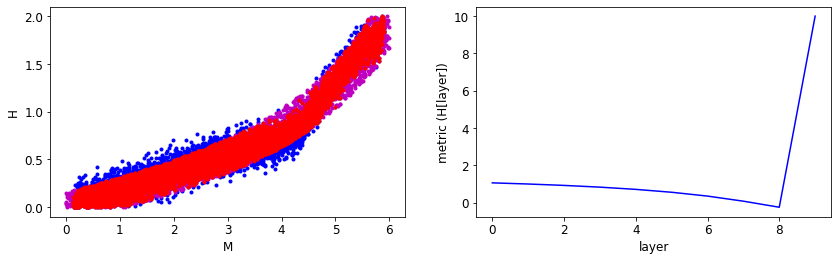

training epoch: 1900,   loss: 0.010376839898526669
m2: 0.0963708683848381, lambda: -0.2214343100786209, alpha: 0.19650880992412567, beta: 0.07873234897851944
[ 1.06197572  1.00008929  0.92543232  0.83198309  0.71280599  0.55780351
  0.35246974  0.07963141 -0.24511118 10.        ]


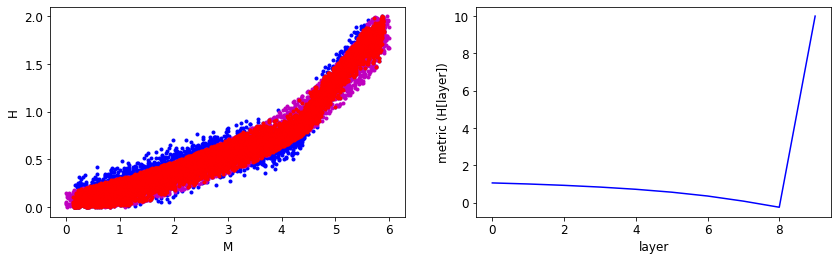

training epoch: 2000,   loss: 0.010332291014492512
m2: 0.09440240263938904, lambda: -0.21848464012145996, alpha: 0.19852778315544128, beta: 0.08129014819860458
[ 1.05363011  0.99697244  0.92404544  0.83152807  0.71246201  0.5572024
  0.3513658   0.0771315  -0.25072721 10.        ]


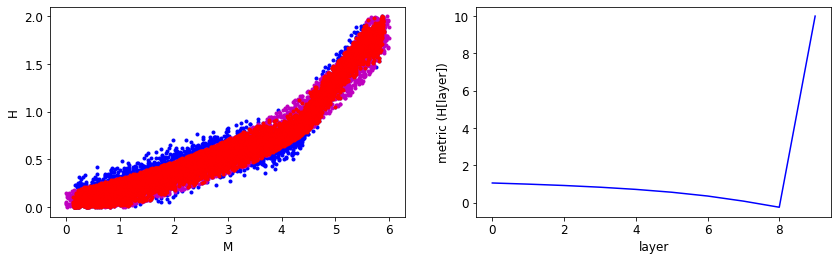

training epoch: 2100,   loss: 0.010357349179685116
m2: 0.09122216701507568, lambda: -0.21451576054096222, alpha: 0.20088987052440643, beta: 0.08068172633647919
[ 1.05046952  0.98869491  0.91613585  0.82437801  0.70718372  0.55452639
  0.35110322  0.0780335  -0.25068456 10.        ]


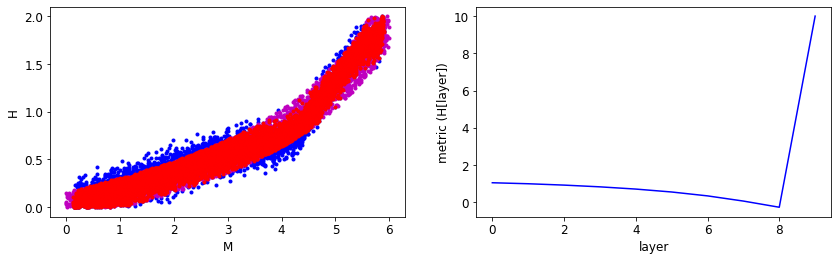

training epoch: 2200,   loss: 0.010450925678014755
m2: 0.09345906972885132, lambda: -0.2131609469652176, alpha: 0.2023431360721588, beta: 0.08292724192142487
[ 1.04391611  0.99022448  0.91731721  0.82391369  0.70388675  0.54706061
  0.33801538  0.05922789 -0.27259222 10.        ]


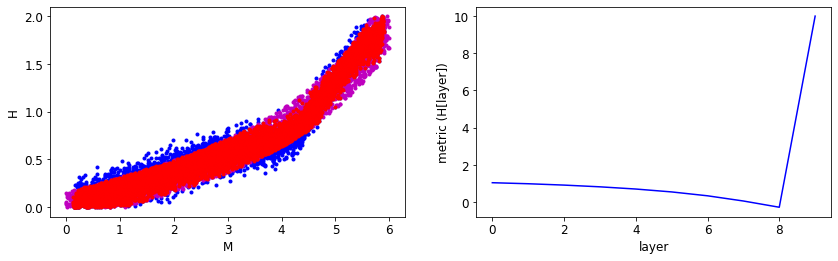

training epoch: 2300,   loss: 0.010356759652495384
m2: 0.09229331463575363, lambda: -0.20621258020401, alpha: 0.20140381157398224, beta: 0.08066315948963165
[ 1.0406841   0.9854719   0.91277826  0.81995106  0.70107228  0.54551494
  0.33713689  0.05734326 -0.27829355 10.        ]


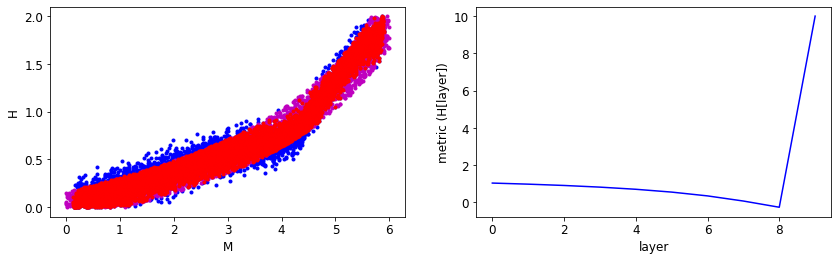

training epoch: 2400,   loss: 0.010443168692290783
m2: 0.08978662639856339, lambda: -0.206274151802063, alpha: 0.2029033899307251, beta: 0.0812041386961937
[ 1.03741169  0.97918046  0.90893614  0.81946945  0.70435667  0.55285764
  0.34878376  0.07295751 -0.26023534 10.        ]


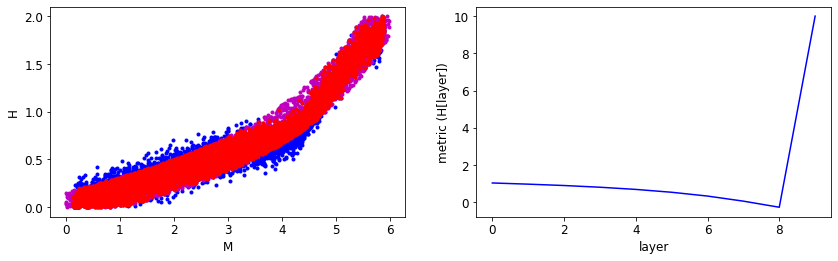

training epoch: 2500,   loss: 0.010790850035846233
m2: 0.09070196747779846, lambda: -0.21044687926769257, alpha: 0.20497383177280426, beta: 0.08060164749622345
[ 1.03327465  0.96945721  0.89627016  0.8046276   0.6871112   0.53372443
  0.32943386  0.05623299 -0.27111241 10.        ]


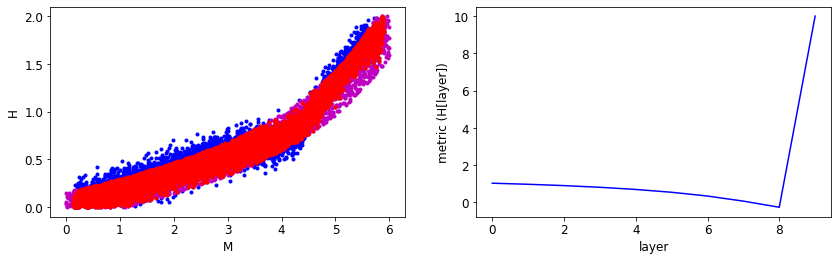

training epoch: 2600,   loss: 0.010132323950529099
m2: 0.08611263334751129, lambda: -0.20504187047481537, alpha: 0.20161373913288116, beta: 0.08304529637098312
[ 1.03315818  0.974796    0.90368521  0.81342959  0.69768929  0.54603791
  0.34317696  0.07058377 -0.25735885 10.        ]


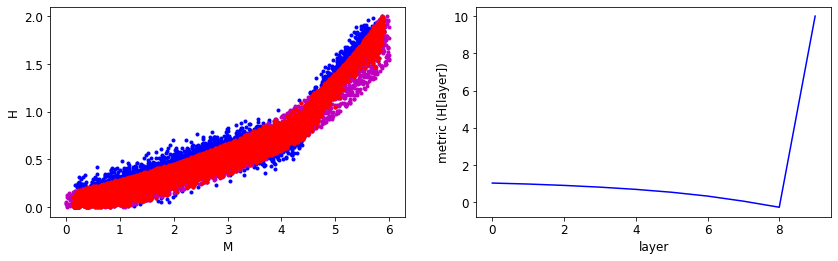

training epoch: 2700,   loss: 0.010293926112353802
m2: 0.08879774808883667, lambda: -0.20439881086349487, alpha: 0.2008402943611145, beta: 0.08590095490217209
[ 1.02994823  0.97699314  0.90405142  0.81056792  0.69101942  0.53580368
  0.33039528  0.0570128  -0.26945826 10.        ]


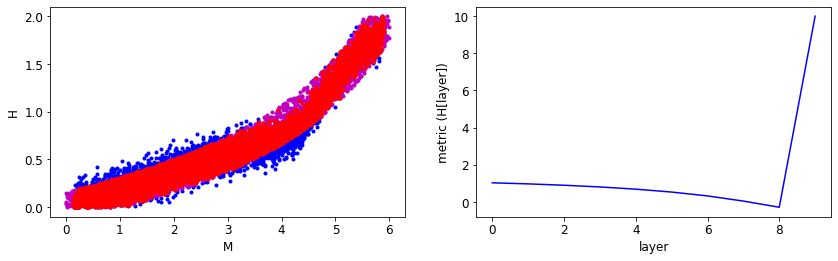

training epoch: 2800,   loss: 0.01069975271821022
m2: 0.09069695323705673, lambda: -0.20721183717250824, alpha: 0.20447662472724915, beta: 0.08095094561576843
[ 1.02629745  0.96860498  0.89567661  0.80314898  0.68418646  0.5282771
  0.32008639  0.04213985 -0.28901383 10.        ]


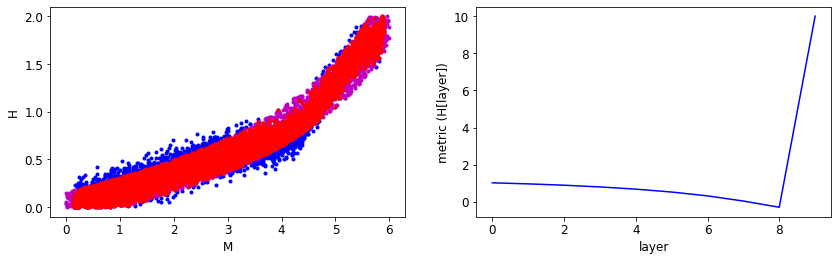

training epoch: 2900,   loss: 0.01016110647469759
m2: 0.08965703099966049, lambda: -0.20478634536266327, alpha: 0.2036908119916916, beta: 0.08158286660909653
[ 1.02487874  0.96773535  0.89636749  0.80391461  0.68468559  0.52895266
  0.32117644  0.04300873 -0.29025656 10.        ]


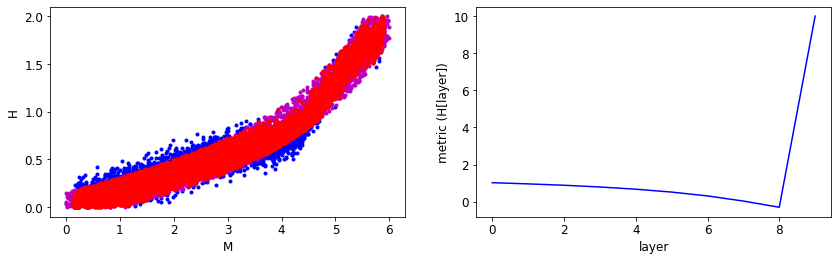

training epoch: 3000,   loss: 0.010481604374945164
m2: 0.08824246376752853, lambda: -0.2067219614982605, alpha: 0.20538629591464996, beta: 0.08144727349281311
[ 1.02643943  0.96154857  0.88826221  0.79532433  0.6759187   0.52026027
  0.31322539  0.03621275 -0.29644302 10.        ]


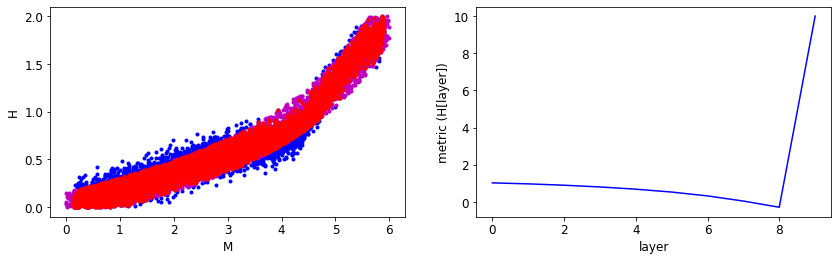

training epoch: 3100,   loss: 0.010352637618780136
m2: 0.09088398516178131, lambda: -0.20522291958332062, alpha: 0.20573772490024567, beta: 0.08368341624736786
[ 1.02337587  0.9698984   0.89710158  0.80352837  0.68409956  0.52849627
  0.32122105  0.04384302 -0.28855771 10.        ]


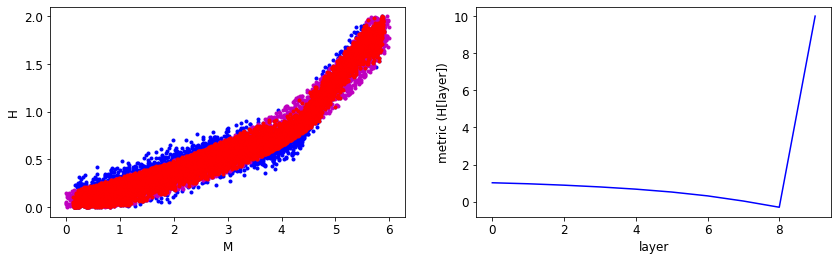

training epoch: 3200,   loss: 0.010022934526205063
m2: 0.09002295136451721, lambda: -0.20397432148456573, alpha: 0.20361898839473724, beta: 0.08286027610301971
[ 1.02150726  0.96708608  0.89157826  0.79696828  0.67755461  0.52238035
  0.31513634  0.03676709 -0.29732564 10.        ]


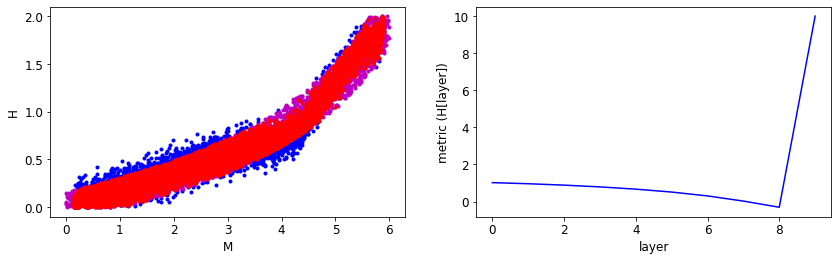

training epoch: 3300,   loss: 0.010036067105829716
m2: 0.08991048485040665, lambda: -0.20572422444820404, alpha: 0.20370079576969147, beta: 0.08290676772594452
[ 1.02175295  0.96264535  0.88686037  0.7914331   0.67051733  0.51351601
  0.30484903  0.02686021 -0.30507085 10.        ]


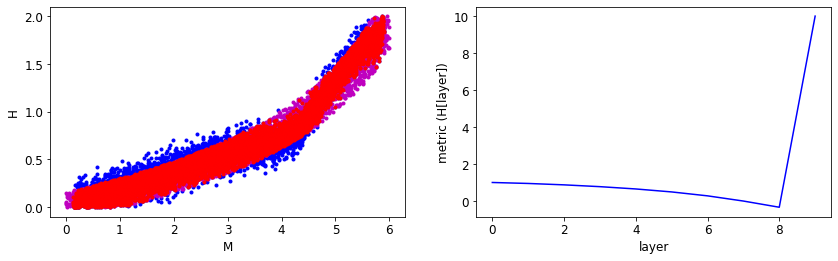

training epoch: 3400,   loss: 0.0100540891289711
m2: 0.09145548194646835, lambda: -0.20272788405418396, alpha: 0.20390087366104126, beta: 0.0852467343211174
[ 1.02423024  0.9715935   0.89612979  0.79873836  0.67467493  0.5142976
  0.30286387  0.02251079 -0.31181404 10.        ]


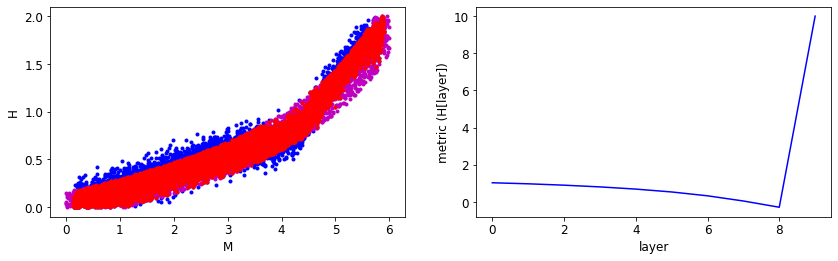

training epoch: 3500,   loss: 0.010435670614242554
m2: 0.0859576016664505, lambda: -0.200860857963562, alpha: 0.20449598133563995, beta: 0.08440092951059341
[ 1.02815402  0.97204566  0.89800721  0.8055464   0.68750238  0.53275949
  0.32532594  0.04616918 -0.28983983 10.        ]


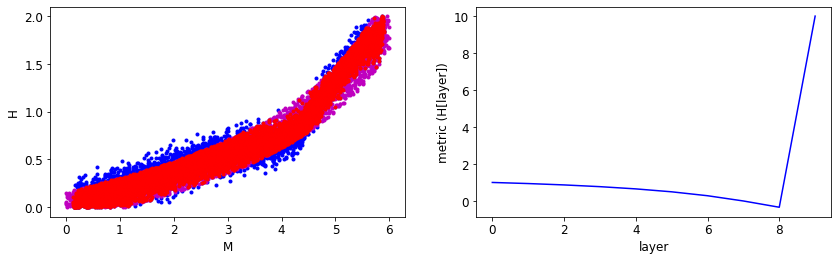

training epoch: 3600,   loss: 0.010213682428002357
m2: 0.08851900696754456, lambda: -0.2000211775302887, alpha: 0.20403307676315308, beta: 0.08320721983909607
[ 1.02713752  0.96789259  0.89396226  0.80032212  0.6801303   0.52224374
  0.310855    0.02788407 -0.3100999  10.        ]


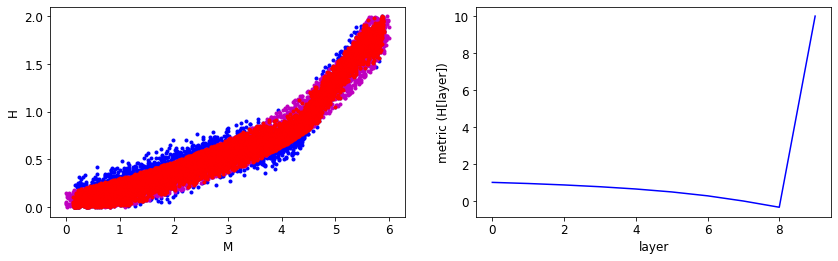

training epoch: 3700,   loss: 0.010497658513486385
m2: 0.08958768844604492, lambda: -0.20642703771591187, alpha: 0.2057095468044281, beta: 0.08519847691059113
[ 1.02540278  0.96439224  0.88699311  0.79054832  0.66825455  0.50984275
  0.29959694  0.01899204 -0.31675971 10.        ]


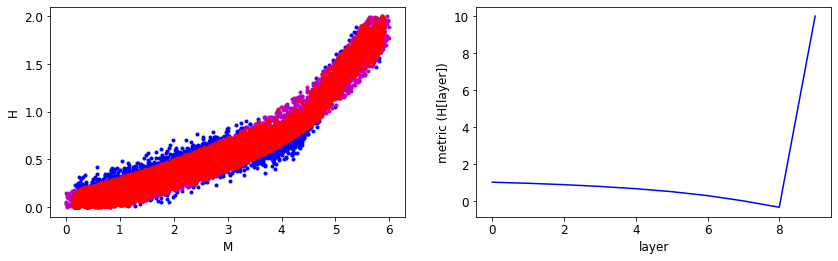

training epoch: 3800,   loss: 0.010189764201641083
m2: 0.09156271070241928, lambda: -0.20283888280391693, alpha: 0.20492564141750336, beta: 0.08253903687000275
[ 1.02300453  0.96504527  0.88994783  0.7942493   0.67203468  0.51237482
  0.29892793  0.01270969 -0.32996234 10.        ]


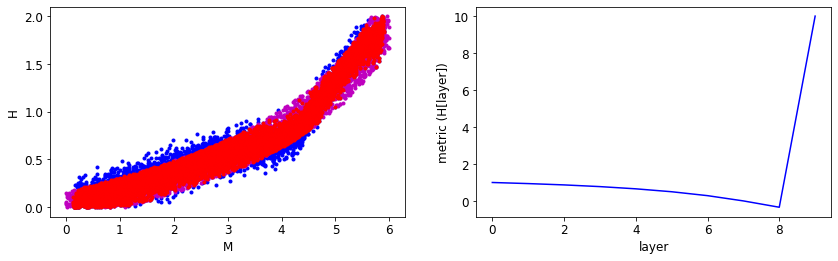

training epoch: 3900,   loss: 0.010369589552283287
m2: 0.08816466480493546, lambda: -0.20150408148765564, alpha: 0.20448996126651764, beta: 0.08278929442167282
[ 1.02462614  0.96541148  0.89421701  0.80236286  0.68282449  0.52538252
  0.31437203  0.03056926 -0.31086326 10.        ]


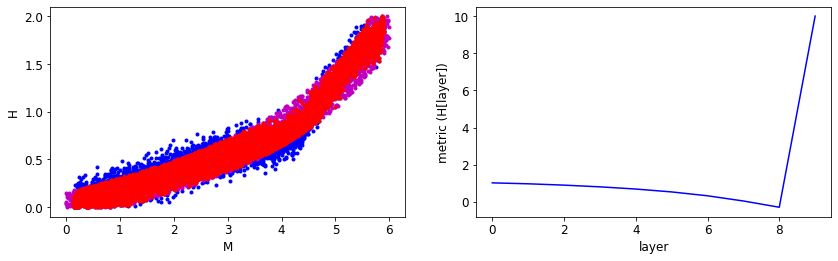

training epoch: 4000,   loss: 0.010261725634336472
m2: 0.09057114273309708, lambda: -0.20293372869491577, alpha: 0.20438173413276672, beta: 0.08367781341075897
[ 1.02029824  0.96984738  0.89794916  0.80599767  0.68745869  0.53204387
  0.32386845  0.04392179 -0.29253739 10.        ]


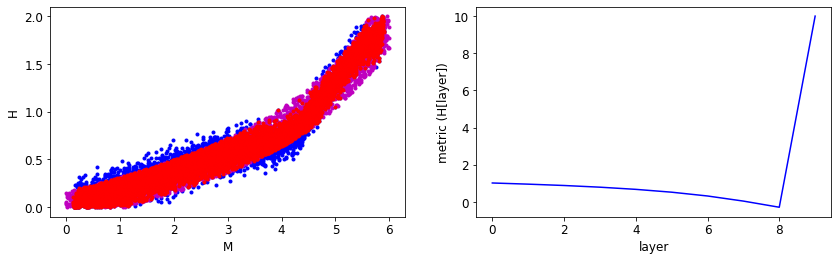

training epoch: 4100,   loss: 0.010128302499651909
m2: 0.08727563172578812, lambda: -0.2013341635465622, alpha: 0.2027873545885086, beta: 0.08040177077054977
[ 1.02052999  0.95765382  0.88542312  0.79442447  0.677683    0.52492857
  0.32064992  0.04608394 -0.28498584 10.        ]


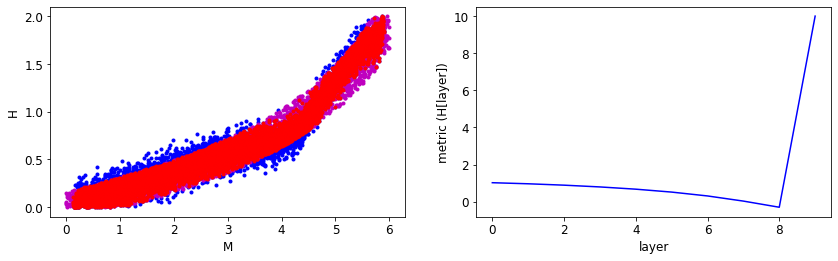

training epoch: 4200,   loss: 0.009965157136321068
m2: 0.09058289974927902, lambda: -0.20172248780727386, alpha: 0.20180518925189972, beta: 0.08255968987941742
[ 1.01919889  0.96155924  0.88669705  0.79156429  0.67056423  0.51358187
  0.30547708  0.0281428  -0.30331114 10.        ]


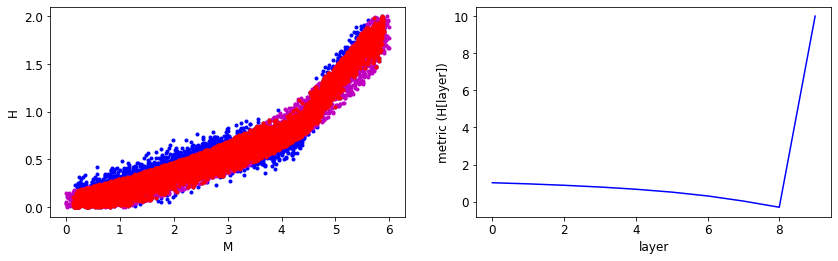

training epoch: 4300,   loss: 0.010647053830325603
m2: 0.08721215277910233, lambda: -0.20535516738891602, alpha: 0.20458382368087769, beta: 0.08489758521318436
[ 1.02333939  0.96255589  0.88645655  0.79252553  0.67338872  0.51857078
  0.31227204  0.03548019 -0.29695666 10.        ]


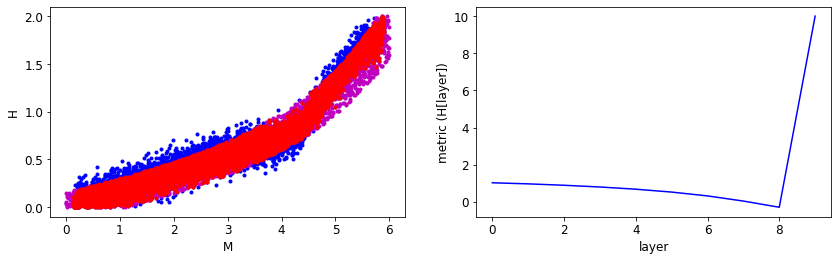

training epoch: 4400,   loss: 0.01030763890594244
m2: 0.08695672452449799, lambda: -0.19911329448223114, alpha: 0.20265375077724457, beta: 0.08393067866563797
[ 1.02454269  0.96624279  0.89093983  0.79772294  0.67875963  0.52368426
  0.31694898  0.03991861 -0.29277462 10.        ]


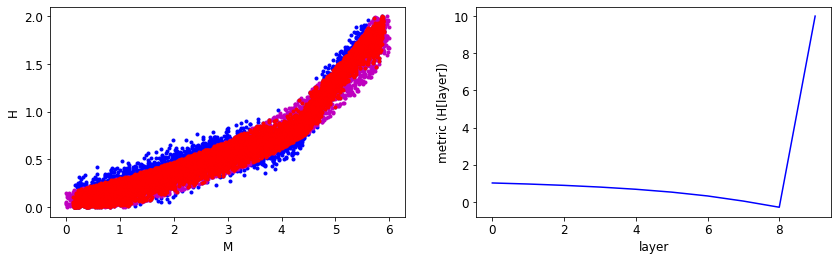

training epoch: 4500,   loss: 0.01023443415760994
m2: 0.08724333345890045, lambda: -0.2006891816854477, alpha: 0.20322701334953308, beta: 0.08340257406234741
[ 1.02268457  0.96616918  0.89392823  0.8020584   0.68398488  0.5298239
  0.32396168  0.04784082 -0.28345239 10.        ]


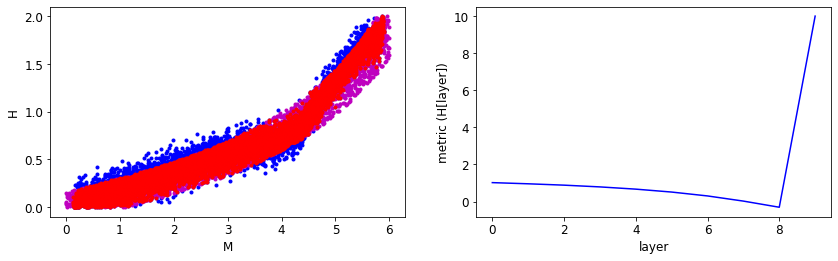

training epoch: 4600,   loss: 0.01006757840514183
m2: 0.08634663373231888, lambda: -0.20211149752140045, alpha: 0.2009388655424118, beta: 0.08309602737426758
[ 1.02268898  0.95948464  0.88611573  0.7919392   0.67129958  0.51398569
  0.30484688  0.02664305 -0.3046968  10.        ]


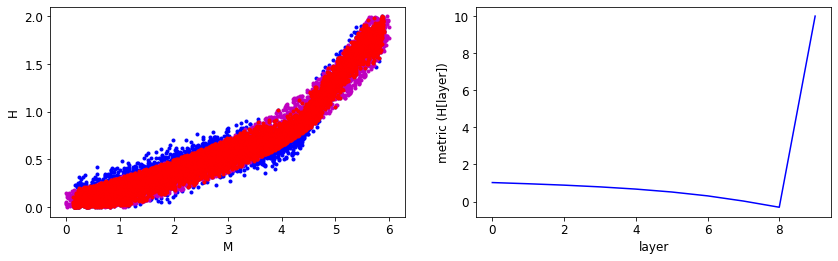

training epoch: 4700,   loss: 0.010424078442156315
m2: 0.08820457011461258, lambda: -0.20429474115371704, alpha: 0.2039204090833664, beta: 0.08149673044681549
[ 1.02229857  0.95763463  0.88299936  0.78957951  0.66998196  0.51335865
  0.30441168  0.02512289 -0.30922365 10.        ]


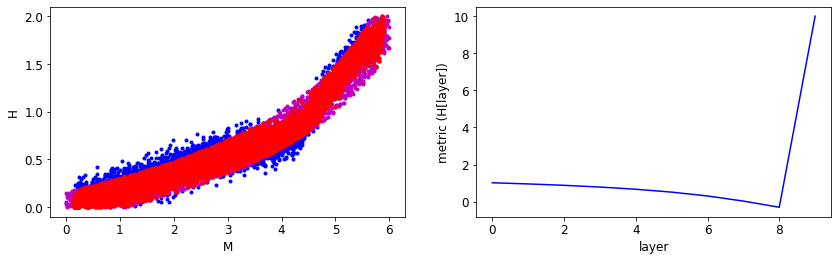

training epoch: 4800,   loss: 0.010340328328311443
m2: 0.08684566617012024, lambda: -0.20435118675231934, alpha: 0.20255737006664276, beta: 0.08265158534049988
[ 1.02075744  0.95816481  0.88366932  0.79078549  0.67217231  0.51701957
  0.3101458   0.03359004 -0.29761446 10.        ]


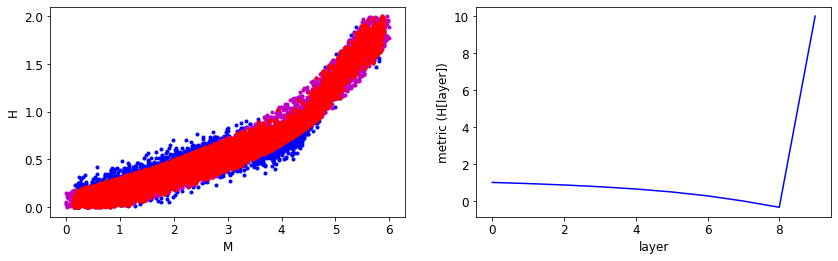

training epoch: 4900,   loss: 0.010303257964551449
m2: 0.09029828011989594, lambda: -0.20762594044208527, alpha: 0.20471705496311188, beta: 0.08246061205863953
[ 1.01910484  0.95754516  0.88216043  0.7869252   0.66463614  0.50539863
  0.29428655  0.01352066 -0.32050467 10.        ]


In [12]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                         positive_H_M_F=Positive_HM, negative_H_M_F=Negative_HM, Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))
        print(np.array([v[0] for v in Hs]))